In [1]:
### ways to improve speed still
### ============================
### - vectorize icdf and dist steps (?)

In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

import mra_utils as mra

In [3]:
def gaussian_2d(N, A=1, sig_x=1, sig_y=1):
    """returns simple 2D Gaussian over range -3 to 3 of size NxN"""
    
    # Make this a better function
    
    xs = np.linspace(-3, 3, N)
    ys = np.linspace(-3, 3, N)

    x, y = np.meshgrid(xs, ys)

    g = A*np.exp(-((x**2 / 2*sig_x**2) + (y**2 / 2*sig_y**2)))
    
    return g

In [4]:
### Generate Gaussian blob image with and without deformation
### - use odd size image for centering

amp = 1000  # a.u.
ny_init = 101  
nx_init = 101

g = gaussian_2d(ny_init, A=amp, sig_x=3, sig_y=3)  # using large amplitude because of scaling

x1 = np.zeros((ny_init, nx_init))

x1[50, 40] = 1
x1[50, 50] = 1
x1[40, 60] = 1

x1 = mra.ift2(mra.ft2(x1) * g)

In [5]:
### Inputs 
# angular_sampling = np.arange(0, 360, 1)  # scales with image for complexity test, how should this be picked in practice
angle = 200  # angle to rotate y2, doesn't really matter for complexity test
###

total_timing = []
preprocess_timing = []
rt_timing = []
icdf_timing = []
dist_timing = []
a_est = []

ns = np.logspace(0, 1.3, 10) # scale factor for Fourier upsample
Ns = ny_init * ns  # approx number of pixels after scaling

for n in ns:

    ### scale image size
    y1 = mra.fourier_upsample(x1.copy(), n)  # don't need to rescale intensity since normalizing to unit mass next
    y2 = y1.copy()
    y2 = mra.rotate(y2, angle)
    ny, nx = y1.shape
    angular_sampling = np.linspace(0, 360, int(n*ny_init), endpoint=False) # scale angular sampling for complexity timing
    # angular_sampling = np.arange(0, 360, 1)
    ###

    t0 = time.time()

    ### preprocess timing
    t1 = time.time()
    y1 = mra.normalize_image_to_unit_mass(y1)
    y2 = mra.normalize_image_to_unit_mass(y2)
    preprocess_timing.append(time.time() - t1)
    ###

    ### radon transform timing
    t2 = time.time()
    rts = mra.fast_radon_transform(np.stack((y1, y2)), angular_sampling)
    y1_rt = rts[0]
    y2_rt = rts[1]
    # y1_rt = mra.fast_radon_transform(y1, angular_sampling)
    # y2_rt = mra.fast_radon_transform(y2, angular_sampling)
    rt_timing.append(time.time() - t2)
    ###

    ### inverse cdf timing
    t3 = time.time()
    grid = np.linspace(0, 1, nx) 
    values = np.arange(nx)
    y1_icdf = mra.convert_radon_transform_to_inverse_cdf(y1_rt, grid, values)
    y2_icdf = mra.convert_radon_transform_to_inverse_cdf(y2_rt, grid, values)
    icdf_timing.append(time.time() - t3)
    ###

    ### distance timing
    t4 = time.time()
    dist_matrix = np.array([mra.fast_shift_computation(y1_icdf[j, :], y2_icdf[j, :]) for j in range(nx)])
    dists = np.sum(dist_matrix, axis=0)
    angle_est = angular_sampling[np.argmin(dists)]
    a_est.append(angle_est)
    dist_timing.append(time.time() - t4)
    ###

    total_timing.append(time.time() - t0)

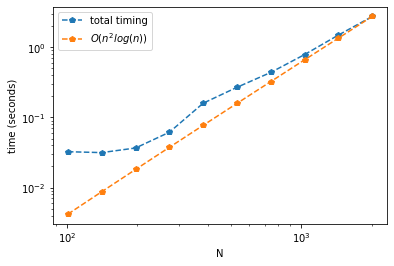

In [6]:
total_scale = total_timing[-1] / (Ns[-1]**2 * np.log(Ns[-1]))

plt.figure(figsize=(6,4))

plt.loglog(Ns, total_timing, 'p--', label='total timing')
plt.loglog(Ns, Ns**2 * np.log(Ns) * total_scale, 'p--', label='$O(n^2 log(n))$')
plt.ylabel('time (seconds)')
plt.xlabel('N')
plt.legend()
plt.show()

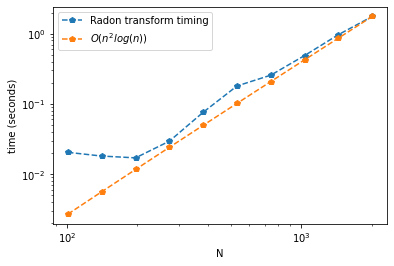

In [7]:
rt_scale = rt_timing[-1] / (Ns[-1]**2 * np.log(Ns[-1]))

plt.figure(figsize=(6,4))

plt.loglog(Ns, rt_timing, 'p--', label='Radon transform timing')
plt.loglog(Ns, Ns**2 * np.log(Ns) * rt_scale, 'p--', label='$O(n^2 log(n))$')
plt.ylabel('time (seconds)')
plt.xlabel('N')
plt.legend()
plt.show()

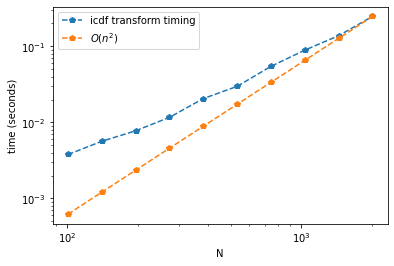

In [8]:
icdf_scale = icdf_timing[-1] / (Ns[-1]**2)   # this step should be ~O(N^2) ?

plt.figure(figsize=(6,4))

plt.loglog(Ns, icdf_timing, 'p--', label='icdf transform timing')
plt.loglog(Ns, Ns**2 * icdf_scale, 'p--', label='$O(n^2)$')
plt.ylabel('time (seconds)')
plt.xlabel('N')
plt.legend()
plt.show()

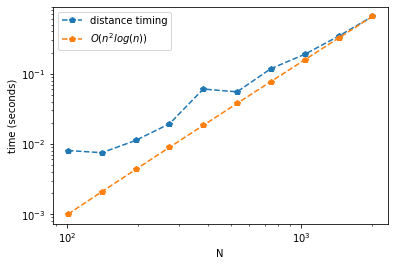

In [9]:
dist_scale = dist_timing[-1] / (Ns[-1]**2 * np.log(Ns[-1]))

plt.figure(figsize=(6,4))

plt.loglog(Ns, dist_timing, 'p--', label='distance timing')
plt.loglog(Ns,  Ns**2 * np.log(Ns) * dist_scale, 'p--', label='$O(n^2 log(n))$')
plt.ylabel('time (seconds)')
plt.xlabel('N')
plt.legend()
plt.show()

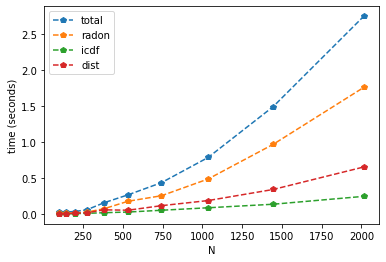

In [10]:
plt.plot(Ns, total_timing, 'p--', label='total')
plt.plot(Ns, rt_timing, 'p--', label='radon')
plt.plot(Ns, icdf_timing, 'p--', label='icdf')
plt.plot(Ns, dist_timing, 'p--', label='dist')
plt.ylabel('time (seconds)')
plt.xlabel('N')
plt.legend()
plt.show()

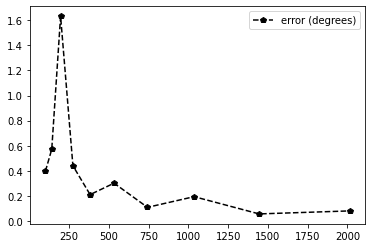

In [11]:
plt.plot(Ns, abs(np.array(a_est) - angle), 'kp--', label='error (degrees)')
plt.legend()
plt.show()

In [12]:
print('number of pixels: ', Ns.astype('int'))
print('\n')
print('  total time (s): ', np.round(total_timing, 2))
print('\n')
print(' estimated angle: ', np.round(a_est, 2))

number of pixels:  [ 101  140  196  273  382  532  742 1036 1445 2015]


  total time (s):  [0.03 0.03 0.04 0.06 0.16 0.27 0.44 0.79 1.49 2.75]


 estimated angle:  [199.6  200.57 198.37 200.44 199.79 200.3  199.89 199.81 200.06 199.92]


In [13]:
# plt.imshow(y1_rt)
# plt.show()
# plt.plot(y1_rt[:, 0])
# plt.plot(y1.sum(axis=0))
# plt.show()